# Analytics - query to reference mapping  

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [1]:
import os
os.environ['R_HOME'] = '/home/cane/miniconda3/envs/hub_paper/lib/R'
import milopy

In [2]:
import scvi
import mplscience
import matplotlib.pyplot as plt
import os
import pynndescent
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scvi.data._download import _download
import anndata

scvi.settings.seed = 1

# plotting commands for the styling
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 1


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

In [3]:
local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub"

## 1️⃣ Download the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [4]:
model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
_download(model_url, local_dir, "model.pt")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


## 2️⃣ Download the query data

For the query, we will use samples from the following publication:  

- Dysregulated lung stroma drives emphysema exacerbation by potentiating resident lymphocytes to suppress an epithelial stem cell reservoir

    Chaoqun Wang
    Ben Hyams
    Nancy C. Allen
    Paul Wolters
    Ari B. Molofsky
    Tien Peng 6


In [5]:
from scvi.data import cellxgene

adata_url = "https://cellxgene.cziscience.com/e/1e5bd3b8-6a0e-4959-8d69-cafed30fe814.cxg/"
adata_immune = cellxgene(adata_url, filename="emphysema_immune.h5ad", save_path=local_dir)
adata_url = "https://cellxgene.cziscience.com/e/4b6af54a-4a21-46e0-bc8d-673c0561a836.cxg/"
adata_nonimmune = cellxgene(adata_url, filename="emphysema_nonimmune.h5ad", save_path=local_dir)
adata_url = "https://cellxgene.cziscience.com/e/214bf9eb-93db-48c8-8e3c-9bb22fa3bc63.cxg/"
adata_at2 = cellxgene(adata_url, filename="emphysema_at2.h5ad", save_path=local_dir)

In [6]:
adata_nonimmune[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype'] = adata_at2[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype']

/tmp/ipykernel_3036950/53203445.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nonimmune[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype'] = adata_at2[np.intersect1d(adata_nonimmune.obs_names, adata_at2.obs_names)].obs['celltype']


In [7]:
query_data = anndata.concat([adata_immune, adata_nonimmune], join='outer', label='compartment', keys=['immune', 'nonimmune'])
query_data.var = adata_nonimmune.var

In [9]:
query_data_raw = query_data.copy()

In [12]:
query_data.obs['dataset'] = query_data.obs['disease']

## 3️⃣ Retrain query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [13]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


INFO     Found 98.5% reference vars in query data.                                                                 


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [14]:
query_data.obs["scanvi_label"] = "unlabeled"

In [15]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [16]:
query_model.adata

AnnData object with n_obs × n_vars = 54085 × 2000
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'compartment', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'

In [17]:
surgery_epochs = 200
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [18]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cuda",
    **train_kwargs_surgery,
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 77/200:  38%|███▊      | 77/200 [04:12<06:43,  3.28s/it, v_num=1, train_loss_step=978, train_loss_epoch=864]  
Monitored metric elbo_train did not improve in the last 10 records. Best score: 945.777. Signaling Trainer to stop.


In [19]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [20]:
query_save_path = f"{local_dir}/query_model_disease_batch"
query_model.save(query_save_path, overwrite=True)

In [23]:
fibroblast_idx = query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # ['Monocyte', 'Macrophage', 'Dendritic cell']) # 

cell_idx1 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'pulmonary emphysema')
cell_idx2 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'normal')

In [25]:
fibroblast.var

,name,feature_is_filtered,feature_name,feature_reference,feature_biotype
ENSG00000000938,FGR,False,FGR,NCBITaxon:9606,gene
ENSG00000000971,CFH,False,CFH,NCBITaxon:9606,gene
ENSG00000002587,HS3ST1,False,HS3ST1,NCBITaxon:9606,gene
ENSG00000002933,TMEM176A,False,TMEM176A,NCBITaxon:9606,gene
ENSG00000003436,TFPI,False,TFPI,NCBITaxon:9606,gene
...,...,...,...,...,...
ENSG00000280721,AC133644.2,False,LINC01943,NCBITaxon:9606,gene
ENSG00000281103,TRG-AS1,False,TRG-AS1,NCBITaxon:9606,gene
ENSG00000282122,NaN,<NA>,NaN,NaN,NaN
ENSG00000282988,RP1-34B20.21,False,RP1-34B20.21,NCBITaxon:9606,gene


In [26]:
de_change = query_model.differential_expression(idx1=cell_idx1, idx2=cell_idx2, batch_correction=True, filter_outlier_cells=True, fdr_target=0.1)
de_change.index = [fibroblast.var.loc[i, 'feature_name'] for i in de_change.index]
de_change[de_change[['non_zeros_proportion1', 'non_zeros_proportion2']].max(1)>0.05].head(50)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.1
CSF3,0.957332,0.042668,3.110694,0.000131,0.000047,0.0,0.25,1.952237,2.061349,3.699093,-11.639425,13.487704,0.600703,0.627022,0.135230,0.061653,1.926082,1.576109,True
HAS1,0.954127,0.045873,3.034911,0.000347,0.000049,0.0,0.25,2.071440,2.006763,3.756656,-11.386698,15.161532,1.100384,0.043288,0.186061,0.013118,3.586693,0.108933,True
CCL19,0.946915,0.053085,2.881316,0.000860,0.000373,0.0,0.25,1.607433,1.741180,3.068333,-9.155317,16.625654,1.903133,0.977700,0.073529,0.108439,5.517086,2.822557,True
CCL2,0.938902,0.061098,2.732236,0.014634,0.005827,0.0,0.25,1.789908,1.838065,2.523957,-9.181843,10.350977,32.217072,5.729340,0.835678,0.409270,127.118882,20.577139,True
CXCL8,0.938702,0.061298,2.728749,0.000893,0.000387,0.0,0.25,1.449996,1.516375,2.491155,-8.172245,9.103741,2.744246,1.780498,0.323210,0.306952,10.286125,6.453551,True
CXCL1,0.937500,0.062500,2.708050,0.001155,0.000465,0.0,0.25,1.497933,1.555354,2.561873,-8.243242,10.350813,2.505115,1.752077,0.250000,0.126804,7.709136,4.706989,True
TFPI2,0.935497,0.064503,2.674363,0.000146,0.000049,0.0,0.25,1.221589,1.215425,2.713682,-8.447968,9.660344,0.313299,0.087014,0.067136,0.023174,1.252463,0.279743,True
SFRP2,0.934896,0.065104,2.664446,0.004078,0.002824,0.0,0.25,0.537042,0.575538,3.079758,-9.286598,9.987947,12.006394,3.955400,0.437020,0.310450,38.713000,13.799741,True
CCL11,0.933694,0.066306,2.644867,0.001454,0.000741,0.0,0.25,1.247704,1.340993,2.477199,-9.229818,10.759650,1.360614,0.516834,0.143862,0.066463,5.313491,2.116643,True
PLA2G2A,0.933293,0.066707,2.638413,0.001542,0.000859,0.0,0.25,0.878609,0.822849,3.206434,-9.313839,11.780990,2.802430,1.057280,0.178708,0.108002,8.772482,3.362907,True


In [27]:
de_change = de_change[de_change[['scale1', 'scale2']].max(1)>1e-4]

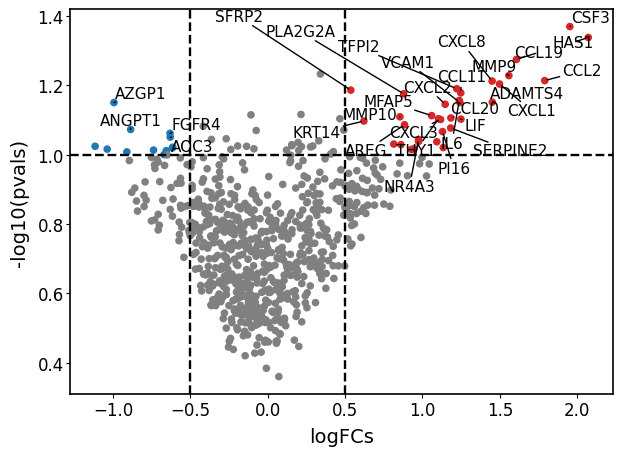

In [28]:
import decoupler as dc

dc.plot_volcano_df(de_change, x='lfc_mean', y='proba_not_de', top=30, sign_thr=0.1, lFCs_thr=0.5, lFCs_limit=3)
plt.savefig(f'{local_dir}/fibroblast_emphysema_scvi_volcano_disease_batch.svg')
plt.show()

In [30]:
pd.options.display.max_columns = None

In [31]:
query_data.obs

,donor_id,nCount_RNA,nFeature_RNA,percent.mt,seurat_clusters,celltype,organism_ontology_term_id,assay_ontology_term_id,self_reported_ethnicity_ontology_term_id,tissue_ontology_term_id,is_primary_data,sex_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,cell_type_ontology_term_id,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,compartment,dataset,scanvi_label,_scvi_batch,_scvi_labels,_scvi_raw_norm_scaling
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGTTCAT-1_1,NL1,2064.0,978,8.624031,1,T cell,NCBITaxon:9606,EFO:0009922,HANCESTRO:0005,UBERON:0002299,True,PATO:0000384,HsapDv:0000157,PATO:0000461,CL:0000084,cell,T cell,10x 3' v3,normal,Homo sapiens,male,alveolus of lung,European,63-year-old human stage,immune,normal,unlabeled,14,28,33.444816
AAACCCAGTCCTCCAT-1_1,NL1,2084.0,1106,7.869482,0,T cell,NCBITaxon:9606,EFO:0009922,HANCESTRO:0005,UBERON:0002299,True,PATO:0000384,HsapDv:0000157,PATO:0000461,CL:0000084,cell,T cell,10x 3' v3,normal,Homo sapiens,male,alveolus of lung,European,63-year-old human stage,immune,normal,unlabeled,14,28,37.174721
AAACCCAGTCGCATGC-1_1,NL1,16808.0,3587,5.021418,2,Monocyte,NCBITaxon:9606,EFO:0009922,HANCESTRO:0005,UBERON:0002299,True,PATO:0000384,HsapDv:0000157,PATO:0000461,CL:0000576,cell,monocyte,10x 3' v3,normal,Homo sapiens,male,alveolus of lung,European,63-year-old human stage,immune,normal,unlabeled,14,28,3.586801
AAACCCATCAAACGTC-1_1,NL1,2377.0,1001,7.824989,0,T cell,NCBITaxon:9606,EFO:0009922,HANCESTRO:0005,UBERON:0002299,True,PATO:0000384,HsapDv:0000157,PATO:0000461,CL:0000084,cell,T cell,10x 3' v3,normal,Homo sapiens,male,alveolus of lung,European,63-year-old human stage,immune,normal,unlabeled,14,28,37.037037
AAACGAAAGCACGATG-1_1,NL1,9414.0,2704,9.400892,4,Monocyte,NCBITaxon:9606,EFO:0009922,HANCESTRO:0005,UBERON:0002299,True,PATO:0000384,HsapDv:0000157,PATO:0000461,CL:0000576,cell,monocyte,10x 3' v3,normal,Homo sapiens,male,alveolus of lung,European,63-year-old human stage,immune,normal,unlabeled,14,28,7.299270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTACGTGAG-1_6,Emp3,18680.0,4631,4.014989,3,Proximal fibroblast,NCBITaxon:9606,EFO:0009922,unknown,UBERON:0002299,True,PATO:0000383,HsapDv:0000167,MONDO:0004849,CL:0000057,cell,fibroblast,10x 3' v3,pulmonary emphysema,Homo sapiens,female,alveolus of lung,unknown,73-year-old human stage,nonimmune,pulmonary emphysema,unlabeled,15,28,2.869440
TTTGGTTGTAGCTCGC-1_6,Emp3,15115.0,3189,9.646047,0,AT2,NCBITaxon:9606,EFO:0009922,unknown,UBERON:0002299,True,PATO:0000383,HsapDv:0000167,MONDO:0004849,CL:0002063,cell,type II pneumocyte,10x 3' v3,pulmonary emphysema,Homo sapiens,female,alveolus of lung,unknown,73-year-old human stage,nonimmune,pulmonary emphysema,unlabeled,15,28,1.833517
TTTGGTTTCTATACGG-1_6,Emp3,5297.0,2375,4.172173,13,Pericyte,NCBITaxon:9606,EFO:0009922,unknown,UBERON:0002299,True,PATO:0000383,HsapDv:0000167,MONDO:0004849,CL:0000669,cell,pericyte,10x 3' v3,pulmonary emphysema,Homo sapiens,female,alveolus of lung,unknown,73-year-old human stage,nonimmune,pulmonary emphysema,unlabeled,15,28,10.330579


## 4️⃣ Query model with donor_id as batch key


Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [32]:
query_data.obs['dataset'] = query_data.obs['donor_id']

In [33]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 100.0% reference vars in query data.                                                                


In [34]:
query_data.obs["scanvi_label"] = "unlabeled"

In [35]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


In [36]:
query_model.adata

AnnData object with n_obs × n_vars = 54085 × 2000
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'compartment', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', '_scvi_raw_norm_scaling'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scanvi_emb'

In [40]:
surgery_epochs = 200
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [41]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cuda",
    **train_kwargs_surgery,
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 140/200:  70%|███████   | 140/200 [07:30<03:13,  3.22s/it, v_num=1, train_loss_step=844, train_loss_epoch=875] 
Monitored metric elbo_train did not improve in the last 10 records. Best score: 941.133. Signaling Trainer to stop.


In [42]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [43]:
query_save_path = f"{local_dir}/query_model_donor_batch"
query_model.save(query_save_path, overwrite=True)

In [46]:
fibroblast_idx = query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # ['Monocyte', 'Macrophage', 'Dendritic cell']) # 

cell_idx1 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'pulmonary emphysema')
cell_idx2 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'normal')

In [48]:
de_change = query_model.differential_expression(idx1=cell_idx1, idx2=cell_idx2, batch_correction=True, filter_outlier_cells=True, fdr_target=0.1)
de_change.index = [query_data.var.loc[i, 'feature_name'] for i in de_change.index]
de_change[de_change[['non_zeros_proportion1', 'non_zeros_proportion2']].max(1)>0.05].head(50)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.1
CSF3,0.9526,0.0474,3.000573,0.000120,0.000036,0.0,0.25,1.685655,1.761772,3.589526,-10.738579,12.473630,0.600703,0.627022,0.135230,0.061653,1.926082,1.576109,True
HAS1,0.9500,0.0500,2.944439,0.000282,0.000048,0.0,0.25,1.845065,1.804728,3.778330,-10.193817,14.525555,1.100384,0.043288,0.186061,0.013118,3.586693,0.108933,True
CCL19,0.9450,0.0550,2.843852,0.000896,0.000406,0.0,0.25,1.296169,1.359950,2.926775,-9.760845,11.922728,1.903133,0.977700,0.073529,0.108439,5.517086,2.822557,True
SFRP2,0.9366,0.0634,2.692792,0.003729,0.002694,0.0,0.25,0.412452,0.397486,3.190744,-9.015327,10.818460,12.006394,3.955400,0.437020,0.310450,38.713000,13.799741,True
PLA2G2A,0.9354,0.0646,2.672760,0.001581,0.000836,0.0,0.25,0.762123,0.685271,3.252587,-9.671732,12.387182,2.802430,1.057280,0.178708,0.108002,8.772482,3.362907,True
CCL2,0.9352,0.0648,2.669455,0.013959,0.005902,0.0,0.25,1.478902,1.507920,2.280169,-8.298656,10.070673,32.217072,5.729340,0.835678,0.409270,127.118882,20.577139,True
TFPI2,0.9342,0.0658,2.653071,0.000168,0.000058,0.0,0.25,1.138752,1.164483,2.722502,-8.295030,9.274859,0.313299,0.087014,0.067136,0.023174,1.252463,0.279743,True
IL6,0.9322,0.0678,2.620985,0.001646,0.000858,0.0,0.25,1.148327,1.218361,2.446579,-7.375415,8.849797,3.982097,1.942282,0.473465,0.243551,15.392476,6.062576,True
MFAP5,0.9314,0.0686,2.608396,0.000408,0.000164,0.0,0.25,0.921447,0.856483,2.618842,-7.154691,12.107700,1.350064,0.324880,0.140026,0.038041,4.108061,0.914125,True
ADAMTS4,0.9306,0.0694,2.595943,0.000783,0.000344,0.0,0.25,1.265907,1.303940,2.305736,-7.718686,8.986758,1.919437,1.490599,0.413683,0.264101,7.376173,5.233019,True


In [49]:
de_change = de_change[de_change[['scale1', 'scale2']].max(1)>1e-4]

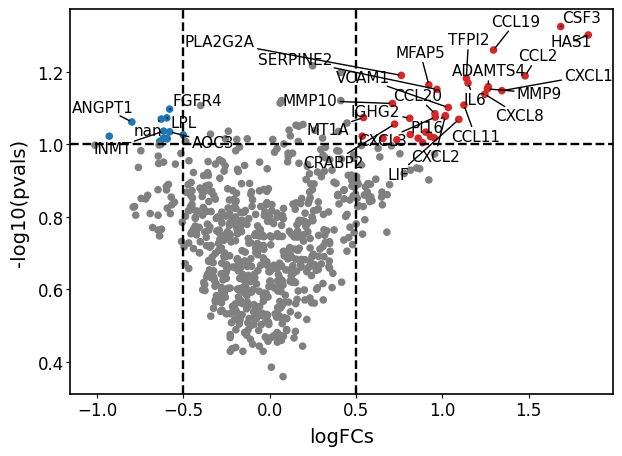

In [50]:
import decoupler as dc

dc.plot_volcano_df(de_change, x='lfc_mean', y='proba_not_de', top=30, sign_thr=0.1, lFCs_thr=0.5, lFCs_limit=3)
plt.savefig(f'{local_dir}/fibroblast_emphysema_scvi_volcano_donor_batch.svg')
plt.show()

## 5️⃣ Train network after unfreezing all layers

Unfreeze network in Arches training

In [58]:
query_data.obs['dataset'] = 'emphysema' # query_data.obs['donor_id']

In [59]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, unfrozen=True)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


In [60]:
query_model.adata

AnnData object with n_obs × n_vars = 54085 × 2000
    obs: 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'celltype', 'organism_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'compartment', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels', '_scvi_raw_norm_scaling'
    var: 'name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scanvi_emb'

In [61]:
query_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  15   │
│         n_cells          │ 54085 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  29   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │   Banovich_Kropski_2020   │          0          │
│                      │     Barbry_Leroy_2020     │          1          │
│                      │ Jain_Misharin_2021_10Xv1  │          2          │
│                      │ Jain_Misharin_2021_10Xv2  │          3          │
│                      │       Krasnow_2020        │          4          │
│                      │ Lafyatis_Rojas_2019_10Xv1 │          5          │
│                      │ Lafyatis_Rojas_2019_10Xv2 │          6          │
│                      │        Meyer_2019         │          7          │
│                      │       Misharin_2021       │          8          │
│                      │  Misharin_Budinger_2018   │          9          │
│                      │        Nawijn_2021        │         10          │
│                      │    Seibold_2020_10Xv2     │         11          │
│                      │    Seibold_2020_10Xv3     │         12          │
│                      │   Teichmann_Meyer_2019    │         13          │
│                      │         emphysema         │         14          │
└──────────────────────┴───────────────────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scanvi_label'] │           AT1           │          0          │
│                           │           AT2           │          1          │
│                           │       Arterial EC       │          2          │
│                           │     B cell lineage      │          3          │
│                           │          Basal          │          4          │
│                           │   Bronchial Vessel 1    │          5          │
│                           │   Bronchial Vessel 2    │          6          │
│                           │        Capillary        │          7          │
│                           │        Ciliated         │          8          │
│                           │     Dendritic cells     │          9          │
│                           │   Fibroblast lineage    │         10          │
│                           │ KRT5- KRT17+ epithelial │         11          │
│                           │      Lymphatic EC       │         12          │
│                           │       Macrophages       │         13          │
│                           │       Mast cells        │         14          │
│                           │     Megakaryocytes      │         15          │
│                           │       Mesothelium       │         16          │
│                           │        Monocytes        │         17          │
│                           │      Neutrophilic       │         18          │
│                           │      Non-T/B cells      │         19          │
│                           │   Proliferating cells   │         20          │
│                           │          Rare           │         21          │
│                           │        Secretory        │         22          │
│                           │      Smooth Muscle      │         23          │
│                           │        Squamous         │         24          │
│                           │  Submucosal Secretory   │         25          │
│                           │     T cell lineage      │         26          │
│                           │         Venous          │         27          │
│                           │        unlabeled        │         28          │
└───────────────────────────┴─────────────────────────┴─────────────────────┘

In [62]:
surgery_epochs = 200
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [63]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cuda",
    **train_kwargs_surgery,
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [11:25<00:00,  3.42s/it, v_num=1, train_loss_step=808, train_loss_epoch=798]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [11:25<00:00,  3.43s/it, v_num=1, train_loss_step=808, train_loss_epoch=798]


In [64]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [65]:
query_save_path = f"{local_dir}/query_model_disease_batch"
query_model.save(query_save_path, overwrite=True)

In [66]:
fibroblast_idx = query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']) # ['Monocyte', 'Macrophage', 'Dendritic cell']) # 

cell_idx1 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'pulmonary emphysema')
cell_idx2 = np.logical_and(query_data.obs["celltype"].isin(['Distal fibroblast', 'Proximal fibroblast', 'Peribronchial fibroblast']), query_data.obs["disease"] == 'normal')

In [67]:
de_change = query_model.differential_expression(idx1=cell_idx1, idx2=cell_idx2, batch_correction=True, filter_outlier_cells=True, fdr_target=0.1)
de_change.index = [query_data.var.loc[i, 'feature_name'] for i in de_change.index]
de_change[de_change[['non_zeros_proportion1', 'non_zeros_proportion2']].max(1)>0.05].head(50)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.1
RPS4Y1,0.991391,0.008609,4.746346,0.000069,0.002855,0.0,0.25,-6.445212,-6.566611,3.135245,-17.805258,5.789589,0.000000,3.052470,0.000000,0.668999,0.000000,15.242600,True
TNFRSF12A,0.987988,0.012012,4.409763,0.001294,0.000141,0.0,0.25,3.239948,3.194398,1.522171,-3.794845,8.666983,3.339194,0.281154,0.717711,0.137298,14.074288,1.133186,True
RHOH,0.985786,0.014214,4.239196,0.000037,0.000006,0.0,0.25,2.845983,2.803960,1.422056,-4.917326,9.888244,0.130754,0.016178,0.085997,0.011806,0.559433,0.075518,True
XCL2,0.984384,0.015616,4.143744,0.000050,0.000005,0.0,0.25,3.616456,3.501220,1.896024,-3.515528,13.736083,0.202685,0.020988,0.074169,0.006996,0.795447,0.081207,True
XIST,0.981782,0.018218,3.986946,0.002660,0.000369,0.0,0.25,4.730344,4.827778,2.549697,-4.272651,13.506973,6.969949,1.315260,0.961317,0.132051,33.249080,4.869295,True
IGLC2,0.979580,0.020420,3.870588,0.001648,0.000206,0.0,0.25,3.378278,3.325336,1.885707,-2.927354,10.653919,3.028453,0.201137,0.705882,0.141233,11.522456,1.046628,True
GZMB,0.979580,0.020420,3.870588,0.000136,0.000015,0.0,0.25,2.941649,2.922228,1.639034,-2.335948,10.792770,0.282289,0.036729,0.113491,0.017927,1.102762,0.167764,True
IGLC7,0.978979,0.021021,3.840987,0.001002,0.000022,0.0,0.25,5.571074,5.248388,3.942796,-7.043673,18.253561,1.533248,0.001749,0.330563,0.001312,5.827105,0.018083,True
HIF3A,0.976977,0.023023,3.747968,0.000108,0.000688,0.0,0.25,-2.965670,-2.931487,1.731500,-9.328031,3.027193,0.226023,1.379099,0.174552,0.632707,1.179995,8.646650,True
HAS1,0.974975,0.025025,3.662535,0.000342,0.000010,0.0,0.25,4.749090,4.799619,3.561942,-8.354258,17.094788,1.100384,0.043288,0.186061,0.013118,3.586693,0.108933,True


In [70]:
de_change = de_change[de_change[['scale1', 'scale2']].max(1)>1e-4]

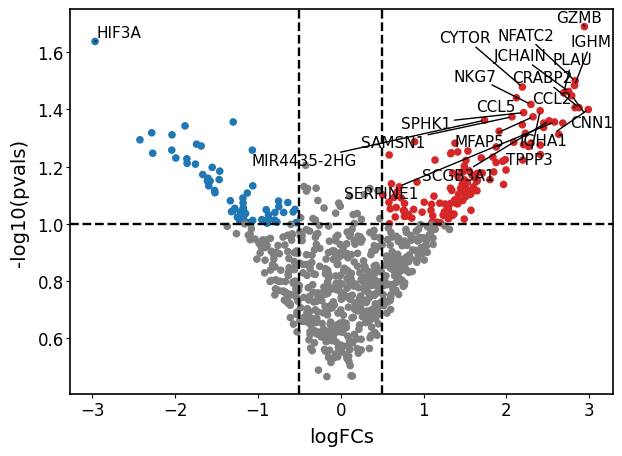

In [71]:
import decoupler as dc

dc.plot_volcano_df(de_change, x='lfc_mean', y='proba_not_de', top=20, sign_thr=0.1, lFCs_thr=0.5, lFCs_limit=3)
plt.savefig(f'{local_dir}/fibroblast_emphysema_scvi_volcano_unfreeze.svg')
plt.show()